# My Continuous Control Implementation

First start by importing some necessary packages for training including the agent

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agent import Agent
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next start up the unity environment

In [2]:
env = UnityEnvironment(file_name="multiArmEnv/Reacher.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Then assign the brain to be used by the unity environment

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Then observe the initial state to find the size of the state and action space to pass to the agents

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

agents = [Agent(state_size, action_size) for agent in range(num_agents)]
print(agents)

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
D4Brain created!
[<agent.Agent object at 0x11798a5f8>, <agent.Agent object at 0x11798af28>, <agent.Agent object at 0x11798af60>, <agent.Agent object at 0x11798af98>, <agent.Agent object at 0x11798afd0>, <agent.Agent object at 0x11798aba8>, <agent.Agent object at 0x1179b42e8>, <agent.Agent object at 0x1179b4320>, <ag

Then we define our training function which, when invoked by default, will:
 - train the agent over at most 2000 episodes
 - allow the agents to spend as much as 10000 units of time or ending when the environment returns a 'done' flag
 - keep track of the most recent 100 episode scores in order to track the recent average (which an avg of >=30 is the "completion condition")

The loop per episode is making the agents come up with the next actions for each agent according to the single local actor network.  Then the environment reflects those actions and the agents observe, commit to their memory, and learn from the rewards and next states that came from those states and corresponding actions.  At the end of every 10 episodes information is printed regarding the current episode score, the previous 100 episode average.  Once the agent acheives an average of >=30 score over the last 100 episodes, it will stop training and save the agent network's local actor weights at *actor_local.pth* and local critic weights at *critic_local.pth*.

In [5]:
def train(episodes=2000, max_time=10000):
    epi_scores = []
    scores_window = deque(maxlen=100)
    
    for episode in range(1, episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)
        
        time = 0
        agents[0].d4.new_episode()
        while time < max_time:
            agents[0].d4.next_timestep()
            time += 1
            actions = [agents[i].act(states[i]) for i in range(num_agents)]
            
            env_info = env.step(actions)[brain_name]

            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done
            
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            
            states = next_states
            scores = np.add(rewards, scores)
            
            agents[0].d4.learn()
            
            if any(dones):
                break
        
        if time == max_time:
            print('well yeah ur timing out')
        scores_window.append(np.mean(scores))
        epi_scores.append(scores)
        if episode % 10 == 0:
            print('Episode {}: Episode Avg Score: {:.4f}, Recent Avg Score: {:.4f}'.format(episode, np.mean(scores), np.mean(scores_window)))
        if np.mean(scores_window) >= 30:
            print("\nSolved!")
            print("Got an average score (over 100 episodes) of {} in {} episodes".format(np.mean(scores_window), episode))
            agents[0].d4.save_state()
            break
    
    return epi_scores

Training is invoked and the entire scores per episode history is saved

In [6]:
scores = train()

Episode 10: Episode Avg Score: 1.0105, Recent Avg Score: 0.6283
Episode 20: Episode Avg Score: 2.1015, Recent Avg Score: 1.2371
Episode 30: Episode Avg Score: 3.7220, Recent Avg Score: 1.9551
Episode 40: Episode Avg Score: 3.6930, Recent Avg Score: 2.4807
Episode 50: Episode Avg Score: 5.9170, Recent Avg Score: 3.0910
Episode 60: Episode Avg Score: 4.6645, Recent Avg Score: 3.4521
Episode 70: Episode Avg Score: 4.2230, Recent Avg Score: 3.7124
Episode 80: Episode Avg Score: 3.9330, Recent Avg Score: 3.7612
Episode 90: Episode Avg Score: 5.0565, Recent Avg Score: 3.7584
Episode 100: Episode Avg Score: 4.8540, Recent Avg Score: 3.8658
Episode 110: Episode Avg Score: 5.8745, Recent Avg Score: 4.3709
Episode 120: Episode Avg Score: 6.0745, Recent Avg Score: 4.7428
Episode 130: Episode Avg Score: 5.5120, Recent Avg Score: 5.0263
Episode 140: Episode Avg Score: 6.0150, Recent Avg Score: 5.2421
Episode 150: Episode Avg Score: 6.2945, Recent Avg Score: 5.5140
Episode 160: Episode Avg Score: 5.

Then we plot the scores over the episodes and should see an upwards trend

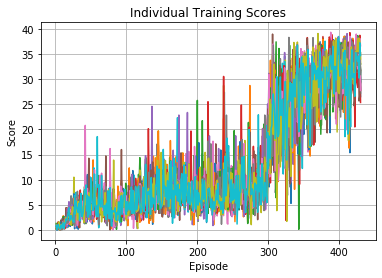

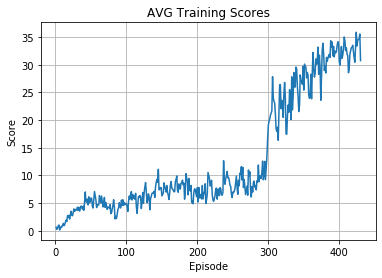

In [9]:
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.grid(True)
plt.title('Individual Training Scores')
plt.show()

plt.plot(range(1, len(scores) + 1), [np.mean(score) for score in scores])
plt.xlabel('Episode')
plt.ylabel('Score')
plt.grid(True)
plt.title('AVG Training Scores')
plt.show()

# See it in action!
The next few cells can be optionally run to see the final version of the agents in action in a non training setting

# (optional) Load saved checkpoint from training
Run this next cell if you want to load alternately saved checkpoints from different training sessions

In [12]:
agents[0].d4.critic_local.load_state_dict(torch.load('critic_local.pth'))
agents[0].d4.actor_local.load_state_dict(torch.load('actor_local.pth'))

# Run it
Run the next cell any number of times to see the agents in action.

In [13]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)

time = 0
agents[0].d4.new_episode()
while time < 10000:
    agents[0].d4.next_timestep()
    time += 1
    actions = [agents[i].act(states[i]) for i in range(num_agents)]

    env_info = env.step(actions)[brain_name]

    next_states = env_info.vector_observations   
    rewards = env_info.rewards                   
    dones = env_info.local_done

    
    states = next_states
    scores = np.add(rewards, scores)

    if any(dones):
        break
print("Completed the episode with Avg score: {}".format(np.mean(scores)))

Completed the episode with Avg score: 34.78499922249466


In [10]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)

time = 0
agents[0].d4.new_episode()
while time < 10000:
    agents[0].d4.next_timestep()
    time += 1
    actions = [agents[i].act(states[i]) for i in range(num_agents)]

    env_info = env.step(actions)[brain_name]

    next_states = env_info.vector_observations   
    rewards = env_info.rewards                   
    dones = env_info.local_done

    
    states = next_states
    scores = np.add(rewards, scores)

    if any(dones):
        break
print("Completed the episode with Avg score: {}".format(np.mean(scores)))

Completed the episode with Avg score: 34.79949922217056


In [14]:
env.close()